# Proteomic profiles of resistance to Brown Ring disease in the Manila clam (Ruditapes philippinarum)

## Introduction
Ce notebook vise à identifier toutes les protéines dont les abondances sont significativement différentes entre deux groupes de palourdes japonaises (Résistantes et Malades) infectées par Vibrio tapetis.
Il propose des améliorations pour effectuer des analyses statistiques appropriées en tenant compte de la distribution des données (normalité et homoscédasticité).

## ## Charger les librairies nécessaires, créer un dossier de sortie si nécessaire

In [3]:
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(dplyr))

In [4]:
#dir.create("outputs", showWarnings = FALSE, recursive = TRUE) 

## Importer les données

In [5]:
protein <- read.csv("input/proteins.csv") # Ce jeu de données pouvant être fourni par l'auteure de l'étude initiale contient les locus des protéines ainsi que l'abondance de la protéine dans chaque échantillon des deux groupes expérimentaux (phénotype résistant et phénotype malade)


## Identifier les protéines d'intérêt (dont l'abondance est significativement différente d'un groupe à l'autre et avec un fold change important) avec un test de comparaison de moyennes approprié aux respect des conditions d'application

In [6]:
# D'abord effectuer un test statistique approprié de différence des moyennes entre les deux groupes et calculer le fold change
# Attention à avoir un nombre de réplicats suffisants pour effectuer un test non-paramétrique (n>5)
#Si ni l’homoscédasticité ni la normalité de la distribution des résidus ne sont respectées dans une comparaison de groupes avec moins de 5 réplicats, aucun test statistique ne peut être effectué. Il est alors nécessaire de se tourner vers des analyses descriptives ou de modifier le protocole pour augmenter le nombre de réplicats.

for (i in 1:nrow(protein)) {
  # Récupérer les données pour les deux groupes et transformer en log2
  sick <- as.numeric(log2(protein[i, 11:13]))
  resistant <- as.numeric(log2(protein[i, 14:16]))
  
  # Remplacer les valeurs infinies (-Inf ou Inf) par NA (log2 de 0 donne -Inf)
  sick[is.infinite(sick)] <- NA
  resistant[is.infinite(resistant)] <- NA
  
  # Vérifier qu'il y a au moins 5 valeurs non-NA et non nulles au total pour effectuer un test
  if (sum(c(sick, resistant) > 0, na.rm = TRUE) >= 5) {
    # Récupérer les intensités totales des top trois peptides (non transformées en log2)
    sick_pept <- as.numeric(protein[i, 26])
    resist_pept <- as.numeric(protein[i, 27])
    
    # Calcul du Fold Change sur la base des top 3 peptides
    protein$Fold_Change[i] <- sick_pept / resist_pept
    protein$Log2_Fold_Change[i] <- log2(sick_pept / resist_pept) # log2 du fold change pour le volcano plot
    
    # Test de normalité avec Shapiro-Wilk (ne fonctionne que pour n >= 3)
    normal_sick <- if (length(na.omit(sick)) >= 3) shapiro.test(sick)$p.value > 0.05 else FALSE
    normal_resistant <- if (length(na.omit(resistant)) >= 3) shapiro.test(resistant)$p.value > 0.05 else FALSE
    
    # Test d'égalité des variances avec test de Levene 
    var_equal <- if (!any(is.na(c(sick, resistant)))) {
      var.test(sick, resistant)$p.value > 0.05
    } else {
      FALSE
    }
    
    # Adapter le test statistique en fonction des conditions
    if (normal_sick && normal_resistant && var_equal) {
      # Test t de Student
      t_test <- t.test(sick, resistant, var.equal = TRUE, na.action = na.omit)
    } else if (normal_sick && normal_resistant && !var_equal) {
      # Test t de Welch (variances inégales)
      t_test <- t.test(sick, resistant, var.equal = FALSE, na.action = na.omit)
    } else {
      # Test de Wilcoxon (non-paramétrique) 
      t_test <- suppressWarnings(wilcox.test(sick, resistant, na.action = na.omit))
    }
    
    # Stocker les résultats
    protein$P_value[i] <- t_test$p.value
    protein$log10P_value[i] <- log10(t_test$p.value) # log10 p_value pour le volcano plot
    
  } else {
    # Si condition des 5 valeurs non remplie, assigner NA à toutes les colonnes calculées
    protein$Fold_Change[i] <- NA
    protein$Log2_Fold_Change[i] <- NA
    protein$P_value[i] <- NA
    protein$log10P_value[i] <- NA
  }
}

In [7]:
# Ajouter une colonne pour catégoriser les protéines (Significativité et importance du fold change)
fold_threshold <- 1.5

protein$Significant <- "Not Significant"
protein$Significant[protein$P_value<0.05] <- "Significant"

protein$Category <- "Not Significant"
protein$Category[protein$P_value < 0.05 & 
                        (protein$Fold_Change >= fold_threshold | 
                           protein$Fold_Change < 1 / fold_threshold)] <- "Significant and high fold change"

# sum(protein$Significant== "Significant") # = 102 Protéines dont l'abondance est significativement différente d'un groupe à l'autre
# sum(protein$Category == "Significant and high fold change") # = 62 ont un fold change important, mais !! IL Y A DES DOUBLONS !!


In [8]:
### Nettoyer le jeux de données pour ne garder que les protéines uniques
protein_unique <- protein %>%
  distinct(Fold_Change, .keep_all = TRUE)

protein_unique$Significant <- "Not Significant"
protein_unique$Significant[protein_unique$P_value<0.05] <- "Significant"

protein_unique$Category <- "Not Significant"
protein_unique$Category[protein_unique$P_value < 0.05 & 
                   (protein_unique$Fold_Change >= fold_threshold | 
                      protein_unique$Fold_Change < 1 / fold_threshold)] <- "Significant and high fold change"

# sum(protein_unique$Significant== "Significant") # = 84 protéines dont l'abondance est significativement différente d'un groupe à l'autre
# sum(protein_unique$Category == "Significant and high fold change") # = 49 ont un fold change important


In [9]:
# Charger les données et créer une nouvelle colonne `locus`
protein_unique <- protein_unique %>%
  mutate(locus = sub(".*\\|Locus_(.*?)\\.p[12].*", "\\1", Accession))

## Locus de toutes les 49 protéines significativement différentes et avec un important fold change
locus_high_fold_proteins <- protein_unique$locus[protein_unique$Category == "Significant and high fold change"]

## Toutes nos 49 protéines d'intérêt 
proteins_of_interest <- protein_unique %>%
  filter(Category == "Significant and high fold change")

## Exporter les données

In [14]:
write.csv2(proteins_of_interest, "outputs/alt_proteins_of_interest.csv")

## Volcano plot

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


[1] 74

[1] 42

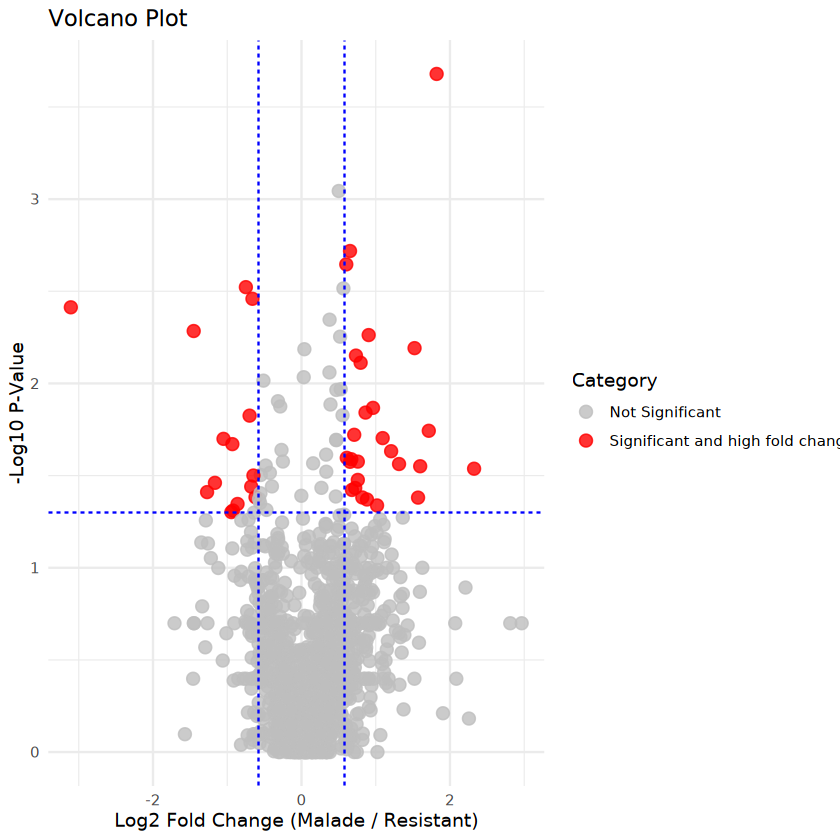

In [10]:
# Le volcano plot (un type de scatter plot) permet de visualiser la distribution des protéines selon le fold change et leur p_value
library(ggplot2)
volcano_plot <- ggplot(protein_unique, aes(x = Log2_Fold_Change, y = abs(log10P_value), color = Category)) +
  geom_point(alpha = 0.8, size = 3) +
  scale_color_manual(values = c("Not Significant" = "grey", "Significant and high fold change" = "red")) +
  geom_vline(xintercept = c(-log2(fold_threshold), log2(fold_threshold)), linetype = "dashed", color = "blue") +
  geom_hline(yintercept = -log10(0.05), linetype = "dashed", color = "blue") +
  theme_minimal() +
  labs(
    title = "Volcano Plot",
    x = "Log2 Fold Change (Malade / Resistant)",
    y = "-Log10 P-Value"
  )

# Afficher le plot
print(volcano_plot)
sum(protein_unique$Significant== "Significant") # = 84 protéines dont l'abondance est significativement différente d'un groupe à l'autre
sum(protein_unique$Category == "Significant and high fold change") # = 49 ont un fold change important



# HEATMAP sur l'intensité des protéines

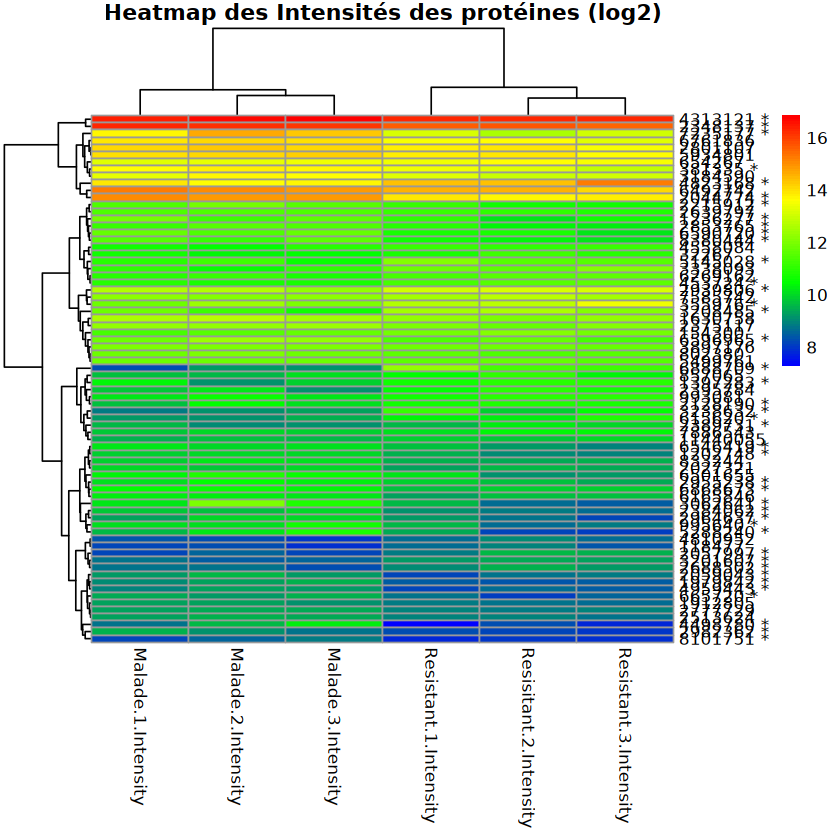

In [11]:
# La heatmap permet de comparer les intensité de protéines dans chaque réplicat et regrouper (cluster) les réplicats selon leur profil d'expression
# Charger les packages
suppressPackageStartupMessages(library(pheatmap))
suppressPackageStartupMessages(library(dendextend))


# Filtrer les protéines significatives
protein_significant_Heatmap <- subset(protein_unique, Significant == "Significant")

# Extraire les intensités des protéines pour les 6 échantillons 
intensite_proteins <- protein_significant_Heatmap[, 11:16]

# Convertir les zéros en NA pour ne pas biaiser les calculs de distances
intensite_proteins[intensite_proteins == 0] <- NA

# Log-transformation deés intensités
heatmap_data_log <- log2(intensite_proteins)
# Ajouter des étoiles aux noms de lignes si condition remplie
stars <- ifelse(protein_significant_Heatmap$Category == "Significant and high fold change", "*", "")
rownames(heatmap_data_log) <- paste(protein_significant_Heatmap$locus, stars)


# Calculer la matrice de distance entre les colonnes (échantillons) en ignorant les NA, avec la méthode euclidienne
distance_matrix_cols <- dist(t(heatmap_data_log), method = "euclidean")

# Effectuer le clustering hiérarchique sur les colonnes
dendro_cols <- hclust(distance_matrix_cols, method = "ward.D2")

# Créer une palette de couleurs allant de bleu au rouge
colors <- colorRampPalette(c("blue", "green", "yellow", "red"))(100)

# Créer la heatmap avec clustering sur les colonnes, noms affichés
pheatmap(
  heatmap_data_log,
  cluster_rows = TRUE,         # Clustering des lignes (protéines)
  cluster_cols = dendro_cols,  # Clustering des colonnes (échantillons)
  color = colors,              # Palette de couleurs
  treeheight_row = 50,         # Taille du dendrogramme des lignes
  treeheight_col = 50,         # Taille du dendrogramme des colonnes
  main = "Heatmap des Intensités des protéines (log2)", 
  labels_row = rownames(heatmap_data_log),  # Locus et étoiles
  labels_col = colnames(heatmap_data_log),  # Afficher noms des échantillons
  na_col = "white"             # Couleur des NA (optionnel : ici blanc)
)

## Les individus malades et résistants forment des groupes distincts, présentant un profil d’expression protéique similaire au sein de chaque groupe.